# Building RNN, LSTM, and GRU for time series using PyTorch

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


# Installing libraries

In [3]:
df = pd.read_excel("/content/cleaned_data_for_solar_forecasting.xlsx")
df

,Unnamed: 0,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Value,EXPORT GENERATION(MWH),IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0,36.4,250.0,36.15,362
1,1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0,36.4,250.0,36.15,362
2,2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0,36.4,250.0,36.15,362
3,3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0,36.4,250.0,36.15,362
4,4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0,36.4,250.0,36.15,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31436,31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31437,31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31438,31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)


In [4]:
df = df[['date', 'Value']]
df

,date,Value
0,2019-05-02 00:00:00,0.0
1,2019-05-02 01:00:00,0.0
2,2019-05-02 02:00:00,0.0
3,2019-05-02 03:00:00,0.0
4,2019-05-02 04:00:00,0.0
...,...,...
31435,2022-12-01 19:00:00,0.0
31436,2022-12-01 20:00:00,0.0
31437,2022-12-01 21:00:00,0.0
31438,2022-12-01 22:00:00,0.0


In [5]:
def plot_dataset(df, title):
  plt.plot(df.index, df.value, label=title)
  plt.legend()
  plt.show()

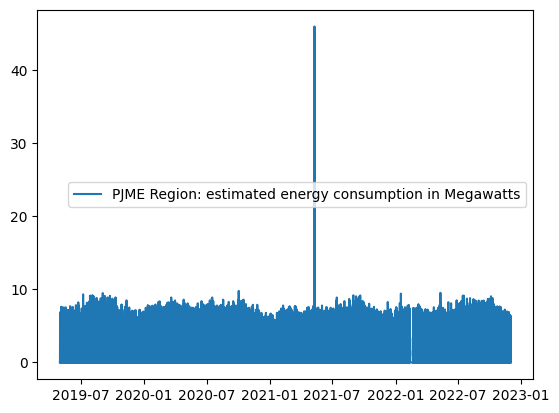

In [6]:
df = df.set_index(['date'])
df = df.rename(columns = {'Value':'value'})

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
  df = df.sort_index()

plot_dataset(df, title='PJME Region: estimated energy consumption in Megawatts')

# Data Visualization

In [7]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []

    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)


In [8]:
df

,value
date,
2019-05-02 00:00:00,0.0
2019-05-02 01:00:00,0.0
2019-05-02 02:00:00,0.0
2019-05-02 03:00:00,0.0
2019-05-02 04:00:00,0.0
...,...
2022-12-01 19:00:00,0.0
2022-12-01 20:00:00,0.0
2022-12-01 21:00:00,0.0


In [9]:
df.columns

Index(['value'], dtype='object')

# Generating time-lagged observations

In [10]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
df_timelags

<ipython-input-10-9686bd7878a4>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
date,,,,,,,,,,,,,,,,,,,,,
2019-05-06 04:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.35,2.69,0.56,0.45,0.00,0.00,0.00,0.00,0.00,0.00
2019-05-06 05:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.99,2.35,2.69,0.56,0.45,0.00,0.00,0.00,0.00,0.00
2019-05-06 06:00:00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6.86,2.99,2.35,2.69,0.56,0.45,0.00,0.00,0.00,0.00
2019-05-06 07:00:00,2.14,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,5.49,6.86,2.99,2.35,2.69,0.56,0.45,0.00,0.00,0.00
2019-05-06 08:00:00,4.05,2.14,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.85,5.49,6.86,2.99,2.35,2.69,0.56,0.45,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 19:00:00,0.00,0.00,0.00,0.58,2.37,4.22,5.51,6.33,6.30,5.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,2.25
2022-12-01 20:00:00,0.00,0.00,0.00,0.00,0.58,2.37,4.22,5.51,6.33,6.30,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57
2022-12-01 21:00:00,0.00,0.00,0.00,0.00,0.00,0.58,2.37,4.22,5.51,6.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Generating date/time predictors

In [11]:
df_features = (
                df
                .assign(hour = df.index.hour)
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year = df.index.week)
              )

<ipython-input-11-c043c9dbbb13>:7: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



# One-hot encoding

In [12]:
def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)

    return pd.concat([df, dummies], axis=1).drop(columns=cols)

df_features = onehot_encode_pd(df_features, ['month','day','day_of_week','week_of_year'])
df_features

,value,hour,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02 00:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-02 01:00:00,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-02 02:00:00,0.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-02 03:00:00,0.0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-02 04:00:00,0.0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 19:00:00,0.0,19,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2022-12-01 20:00:00,0.0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2022-12-01 21:00:00,0.0,21,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Generating cyclical features (sin/cos transformation)

In [13]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_features = generate_cyclical_features(df_features, 'hour', 24, 0)
# df_features = generate_cyclical_features(df_features, 'day_of_week', 7, 0)
# df_features = generate_cyclical_features(df_features, 'month', 12, 1)
# df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)

df_features

,value,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,...,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,sin_hour,cos_hour
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02 00:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2019-05-02 01:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.258819,0.965926
2019-05-02 02:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,0.866025
2019-05-02 03:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.707107,0.707107
2019-05-02 04:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 19:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.965926,0.258819
2022-12-01 20:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.866025,0.500000
2022-12-01 21:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.707107,0.707107


# Other date/time-related features

In [14]:
from datetime import date
import holidays

us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))


df_features = add_holiday_col(df_features, us_holidays)
df_features

,value,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,...,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,sin_hour,cos_hour,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02 00:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1.000000,0
2019-05-02 01:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.258819,0.965926,0
2019-05-02 02:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.500000,0.866025,0
2019-05-02 03:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.707107,0.707107,0
2019-05-02 04:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.866025,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 19:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.965926,0.258819,0
2022-12-01 20:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.866025,0.500000,0
2022-12-01 21:00:00,0.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.707107,0.707107,0


# Splitting the data into test, validation, and train sets

In [15]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features, 'value', 0.2)

# Applying scale transformation

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [17]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

# Loading the data into DataLoaders

In [18]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

# Defining the RNN model classes

## Vanilla RNN

In [19]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

# Long Short-Term Memory (LSTM)

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

# Gated Recurrent Unit (GRU)

In [21]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [22]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

# Making predictions

In [23]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                yhat=yhat.cpu().data.numpy()
                predictions.append(yhat)
                y_test=y_test.cpu().data.numpy()
                values.append(y_test)

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.style.use('ggplot')
        plt.figure(figsize=(10,5))
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

# Training the model

In [24]:
import torch.optim as optim
def General_Settings(model_name):

        input_dim = len(X_train.columns)
        output_dim = 1
        hidden_dim = 64
        layer_dim = 3
        batch_size = 64
        dropout = 0.2
        n_epochs = 20
        learning_rate = 1e-3
        weight_decay = 1e-6

        model_params = {'input_dim': input_dim,
                        'hidden_dim' : hidden_dim,
                        'layer_dim' : layer_dim,
                        'output_dim' : output_dim,
                        'dropout_prob' : dropout}
        model = get_model(model_name, model_params)
        loss_fn = nn.MSELoss(reduction="mean")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        opt = Optimization(model=model.to(device), loss_fn=loss_fn, optimizer=optimizer)
        opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
        opt.plot_losses()

        predictions, values = opt.evaluate(
            test_loader_one,
            batch_size=1,
            n_features=input_dim
        )
        return predictions,values

# Formatting the predictions

In [25]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


# Calculating error metrics

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics



# Generating baseline predictions

In [27]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

# Visualizing the predictions

In [28]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
plt.style.use('ggplot')

def plot_predictions(df_result, df_baseline):
    data = []

    value = go.Scatter(
        x=df_result.index,
        y=df_result.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='linear regression',
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)

    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='predictions',
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)

    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

# Main

[1/20] Training loss: 0.0017	 Validation loss: 0.0016
[2/20] Training loss: 0.0014	 Validation loss: 0.0017
[3/20] Training loss: 0.0016	 Validation loss: 0.0014
[4/20] Training loss: 0.0014	 Validation loss: 0.0016
[5/20] Training loss: 0.0015	 Validation loss: 0.0014
[6/20] Training loss: 0.0011	 Validation loss: 0.0009
[7/20] Training loss: 0.0009	 Validation loss: 0.0013
[8/20] Training loss: 0.0007	 Validation loss: 0.0009
[9/20] Training loss: 0.0007	 Validation loss: 0.0009
[10/20] Training loss: 0.0007	 Validation loss: 0.0009


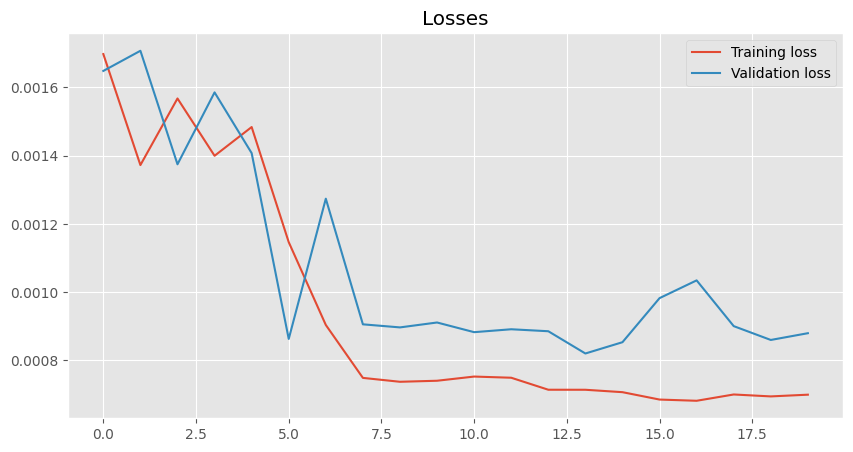

Mean Absolute Error:        0.8727761
Root Mean Squared Error:    1.310016826201259
R^2 Score:                  0.7037728172590438
{'mae': 0.8727761, 'rmse': 1.310016826201259, 'r2': 0.7037728172590438}
Mean Absolute Error:        1.1527424578872951
Root Mean Squared Error:    1.4412003535492792
R^2 Score:                  0.6414746602722414
{'mae': 1.1527424578872951, 'rmse': 1.4412003535492792, 'r2': 0.6414746602722414}


In [29]:
# model_name=Enter model name 'lstm','rnn','gru'
model_name='rnn'
predictions, values=General_Settings(model_name)
df_result=format_predictions(predictions, values, X_test, scaler)
print(calculate_metrics(df_result))
df_baseline = build_baseline_model(df_features, 0.2, 'value')
print(calculate_metrics(df_baseline))
plot_predictions(df_result, df_baseline)

[1/20] Training loss: 0.0014	 Validation loss: 0.0010
[2/20] Training loss: 0.0009	 Validation loss: 0.0009
[3/20] Training loss: 0.0009	 Validation loss: 0.0008
[4/20] Training loss: 0.0008	 Validation loss: 0.0010
[5/20] Training loss: 0.0007	 Validation loss: 0.0009
[6/20] Training loss: 0.0007	 Validation loss: 0.0008
[7/20] Training loss: 0.0007	 Validation loss: 0.0008
[8/20] Training loss: 0.0007	 Validation loss: 0.0010
[9/20] Training loss: 0.0007	 Validation loss: 0.0010
[10/20] Training loss: 0.0007	 Validation loss: 0.0008


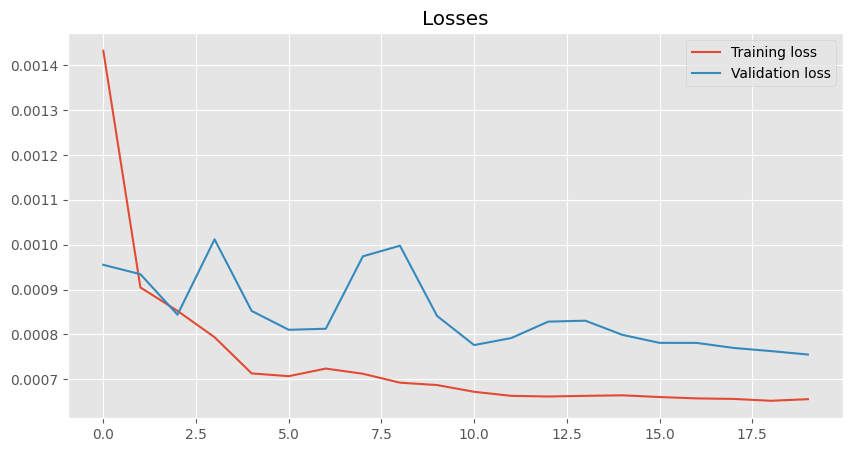

Mean Absolute Error:        0.6547959
Root Mean Squared Error:    1.1474269131424986
R^2 Score:                  0.7727409350705511
{'mae': 0.6547959, 'rmse': 1.1474269131424986, 'r2': 0.7727409350705511}
Mean Absolute Error:        1.1527424578872951
Root Mean Squared Error:    1.4412003535492792
R^2 Score:                  0.6414746602722414
{'mae': 1.1527424578872951, 'rmse': 1.4412003535492792, 'r2': 0.6414746602722414}


In [30]:
# model_name=Enter model name 'lstm','rnn','gru'
model_name='lstm'
predictions, values=General_Settings(model_name)
df_result=format_predictions(predictions, values, X_test, scaler)
print(calculate_metrics(df_result))
df_baseline = build_baseline_model(df_features, 0.2, 'value')
print(calculate_metrics(df_baseline))
plot_predictions(df_result, df_baseline)

[1/20] Training loss: 0.0014	 Validation loss: 0.0013
[2/20] Training loss: 0.0010	 Validation loss: 0.0010
[3/20] Training loss: 0.0010	 Validation loss: 0.0009
[4/20] Training loss: 0.0008	 Validation loss: 0.0011
[5/20] Training loss: 0.0008	 Validation loss: 0.0009
[6/20] Training loss: 0.0008	 Validation loss: 0.0009
[7/20] Training loss: 0.0008	 Validation loss: 0.0008
[8/20] Training loss: 0.0007	 Validation loss: 0.0010
[9/20] Training loss: 0.0007	 Validation loss: 0.0009
[10/20] Training loss: 0.0007	 Validation loss: 0.0008


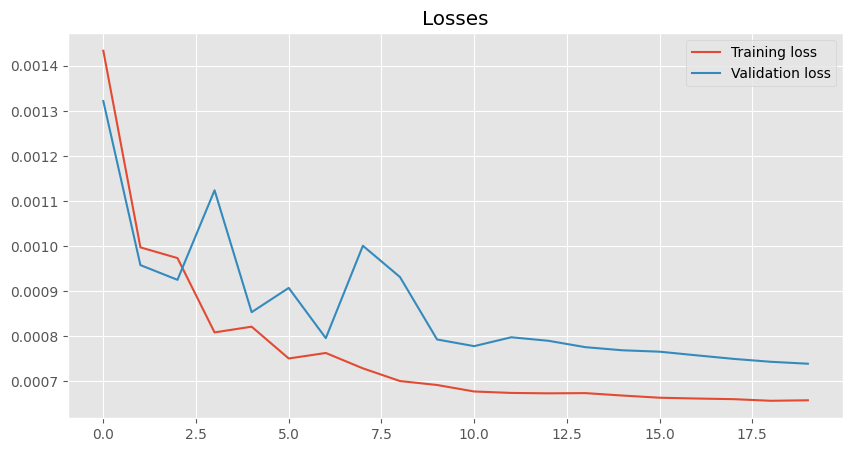

Mean Absolute Error:        0.6192498
Root Mean Squared Error:    1.1050998355247121
R^2 Score:                  0.7891982426332198
{'mae': 0.6192498, 'rmse': 1.1050998355247121, 'r2': 0.7891982426332198}
Mean Absolute Error:        1.1527424578872951
Root Mean Squared Error:    1.4412003535492792
R^2 Score:                  0.6414746602722414
{'mae': 1.1527424578872951, 'rmse': 1.4412003535492792, 'r2': 0.6414746602722414}


In [31]:
# model_name=Enter model name 'lstm','rnn','gru'
model_name='gru'
predictions, values=General_Settings(model_name)
df_result=format_predictions(predictions, values, X_test, scaler)
print(calculate_metrics(df_result))
df_baseline = build_baseline_model(df_features, 0.2, 'value')
print(calculate_metrics(df_baseline))
plot_predictions(df_result, df_baseline)